# T3 de NoIA

Neste trabalho, vamos aprender a utilizar duas técnicas diferentes de tradução automática, em que a primeira utilizará-se a estatística e, a segunda, Machine Learning na arquitetura codificador-decodificador.

Para que funcione corretamente, vá ao site https://www.statmt.org/europarl/ , encontre o link “parallel corpus Portuguese-English” o baixe e crie uma pasta "texts" e coloque os dois arquivos que serão baixados nessa pasta "texts "na raiz do projeto.

## Alunos
- **Arthur de Sá Antero - 212006577**
- **Arthur Mota Furtado - 200014935**

In [14]:
import re
from nltk.translate import IBMModel1, AlignedSent
from nltk.translate.bleu_score import sentence_bleu

# Carregamento de dados

Primeiro, carrega-se os textos baixados em duas matrizes, uma com tudo em português e, outra, com tudo em inglês. Cada um dos textos possuem textos do parlamento europeu nas duas línguas, tendo o mesmo conteúdo que nos ajudará a treinar um modelo de tradução.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

file_en = "texts/europarl-v7.pt-en.en"
file_pt = "texts/europarl-v7.pt-en.pt"

with open(file_en, "r", encoding="utf-8") as f_en, open(file_pt, "r", encoding="utf-8") as f_pt:
    source_sentences = f_en.readlines()  # Inglês
    target_sentences = f_pt.readlines()  # Português

source_sentences = [clean_text(line.strip()).split() for line in source_sentences[:50000]]
target_sentences = [clean_text(line.strip()).split() for line in target_sentences[:50000]]

print("Inglês:", source_sentences[:5])
print("Português:", target_sentences[:5])

Inglês: [['resumption', 'of', 'the', 'session'], ['i', 'declare', 'resumed', 'the', 'session', 'of', 'the', 'european', 'parliament', 'adjourned', 'on', 'friday', '17', 'december', '1999', 'and', 'i', 'would', 'like', 'once', 'again', 'to', 'wish', 'you', 'a', 'happy', 'new', 'year', 'in', 'the', 'hope', 'that', 'you', 'enjoyed', 'a', 'pleasant', 'festive', 'period'], ['although', 'as', 'you', 'will', 'have', 'seen', 'the', 'dreaded', 'millennium', 'bug', 'failed', 'to', 'materialise', 'still', 'the', 'people', 'in', 'a', 'number', 'of', 'countries', 'suffered', 'a', 'series', 'of', 'natural', 'disasters', 'that', 'truly', 'were', 'dreadful'], ['you', 'have', 'requested', 'a', 'debate', 'on', 'this', 'subject', 'in', 'the', 'course', 'of', 'the', 'next', 'few', 'days', 'during', 'this', 'partsession'], ['in', 'the', 'meantime', 'i', 'should', 'like', 'to', 'observe', 'a', 'minute', 's', 'silence', 'as', 'a', 'number', 'of', 'members', 'have', 'requested', 'on', 'behalf', 'of', 'all', '

# IBM Model 1

O primeiro modelo que criaremos de tradução automática será puramente estatístico e simples chamado IBM Model 1, que basicamente aprenderá a olhar frase por frase dos dois textos que temos como dados, com a quantidade de frases que decidimos colocar para ele ler, e aprender a traduzir com base nessas duas línguas e cada frase traduzida nesses dois textos. Assim, o modelo ficará limitado a frases específicas do parlamento europeu, que pode ser um pouco formal demais e também fica limitado a uma certa quantidade de frases que decidimos que será treinado, pois pegar os dois textos inteiros demoraria muito.

In [16]:
bitext = [AlignedSent(target, source) for source, target in zip(source_sentences, target_sentences)]
print(bitext[:5])

ibm_model = IBMModel1(bitext, 5)

[AlignedSent(['reinício', 'da', 'sessão'], ['resumption', 'of', 'the', 'session'], Alignment([])), AlignedSent(['declaro', 'reaberta', 'a', 'sessão', 'do', 'parlamento', 'europeu', 'que', 'tinha', 'sido', 'interrompida', 'na', 'sextafeira', '17', 'de', 'dezembro', 'último', 'e', 'renovo', 'todos', 'os', 'meus', 'votos', 'esperando', 'que', 'tenham', 'tido', 'boas', 'férias'], ['i', 'declare', 'resumed', 'the', 'session', 'of', 'the', 'european', 'parliament', 'adjourned', 'on', 'friday', '17', 'december', '1999', 'and', 'i', 'would', 'like', 'once', 'again', 'to', 'wish', 'you', 'a', 'happy', 'new', 'year', 'in', 'the', 'hope', 'that', 'you', 'enjoyed', 'a', 'pleasant', 'festive', 'period'], Alignment([])), AlignedSent(['como', 'puderam', 'constatar', 'o', 'grande', 'bug', 'do', 'ano', '2000', 'não', 'aconteceu', 'em', 'contrapartida', 'os', 'cidadãos', 'de', 'alguns', 'dos', 'nossos', 'países', 'foram', 'vítimas', 'de', 'catástrofes', 'naturais', 'verdadeiramente', 'terríveis'], ['alt

# Avaliação

Para a avaliação das traduções, utilizou-se o BLEU, que pega a tradução feita e compara com a frase de referência e avalia em um valor de 0 a 1 o quão boa foi a tradução, em que 0 é que a tradução está completamente diferente da referência e 1 é que a tradução é idêntica a referência.

In [17]:

reference = [['this', 'is', 'a', 'test']]
candidate = ['this', 'is', 'a', 'trial']
score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(score)

0.75


A função a seguir traduz um texto que você passa a ela utilizando o IBM Model 1 que foi feito acima.

In [23]:
def translate_input(ibm_model, source_text):
    translated_words = []
    for source_word in source_text:
        max_prob = 0.0
        translated_word = None
        for target_word in ibm_model.translation_table[source_word]:
            prob = ibm_model.translation_table[source_word][target_word]
            if prob > max_prob:
                max_prob = prob
                translated_word = target_word
        if translated_word is not None:
            translated_words.append(translated_word)

    return translated_words

O trecho a seguir de código pega 100 frases dos próprios textos em que a IBM Model 1 foi treinada, as traduz e avalia as traduções utilizando o BLEU citado acima nas avaliações, fazendo uma média aritmética de todos os "scores" de tradução dado pelo BLEU.

In [25]:
scores = []
for i in range(100):
  sentence = target_sentences[1000 + i]
  correct_sentence = source_sentences[1000 + i]
  translation = translate_input(ibm_model, sentence)
  scores.append(sentence_bleu([correct_sentence], translation,weights=(1, 0, 0, 0)))
score = sum(scores) / len(scores)
print(score)

0.2760668194483066


In [ ]:
import collections
import math
import tensorflow as tf
from d2l import tensorflow as d2l

class MTFraEng(d2l.DataModule):  #@save
    """The English-French dataset."""
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

data = MTFraEng()
raw_text = data._download()
print(raw_text[:75])

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)

    def call(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(tf.transpose(X))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state


class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def call(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        # Concat at the feature dimension
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return tf.keras.optimizers.Adam(learning_rate=self.lr)
    
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
with d2l.try_gpu():
    encoder = Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)


Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !

5


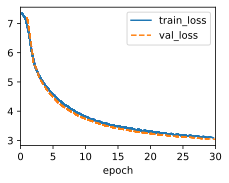

In [69]:
import re
import tensorflow as tf
from d2l import tensorflow as d2l

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

class MTEngPor(d2l.DataModule):  #@save
    """The English-Portuguese dataset."""
    def _download(self):
        file_en = "texts/europarl-v7.pt-en.en"
        file_pt = "texts/europarl-v7.pt-en.pt"
        
        with open(file_en, "r", encoding="utf-8") as f_en, open(file_pt, "r", encoding="utf-8") as f_pt:
            source_sentences = f_en.readlines()
            target_sentences = f_pt.readlines()
        
        # Preprocess and tokenize
        source_sentences = [clean_text(line.strip()).split() for line in source_sentences[:50000]]
        target_sentences = [clean_text(line.strip()).split() for line in target_sentences[:50000]]
        
        return source_sentences, target_sentences
    
    def __init__(self, batch_size=128, num_steps=10):
        super().__init__()
        self.batch_size, self.num_steps = batch_size, num_steps
        self.src, self.tgt = self._download()
        self.src_vocab = d2l.Vocab(self.src, min_freq=2)
        self.tgt_vocab = d2l.Vocab(self.tgt, min_freq=2)
    
    def _build_arrays(self, lines, vocab, max_len):
        arrays = []
        for line in lines:
            if len(line) < max_len:
                line = line + ['<pad>'] * (max_len - len(line))  # Padding
            arrays.append(vocab[line[:max_len]])  # Truncate if necessary
        return arrays

    
    def get_dataloader(self, train=True):
        src_array = self._build_arrays(self.src, self.src_vocab, self.num_steps)
        tgt_array = self._build_arrays(self.tgt, self.tgt_vocab, self.num_steps)

        # Ensure same length with padding
        src_array = [seq + [self.src_vocab['<pad>']] * (self.num_steps - len(seq)) for seq in src_array]
        tgt_array = [seq + [self.tgt_vocab['<pad>']] * (self.num_steps - len(seq)) for seq in tgt_array]

        # Convert lists to tensors
        src_tensor = tf.convert_to_tensor(src_array, dtype=tf.int32)
        tgt_tensor = tf.convert_to_tensor(tgt_array, dtype=tf.int32)

        # Split into decoder input and target output
        dec_X = tgt_tensor[:, :-1]  # All except last token
        tgt_Y = tgt_tensor[:, 1:]   # Shifted target sequence

        return d2l.load_array((src_tensor, dec_X, tgt_Y), self.batch_size)



# Load data
data = MTEngPor(batch_size=128)

# Model parameters
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
    
    def call(self, X, *args):
        embs = self.embedding(tf.transpose(X))
        outputs, state = self.rnn(embs)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.dense = tf.keras.layers.Dense(vocab_size)
    
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    
    def call(self, X, state):
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        context = enc_output[-1]
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder-decoder for sequence-to-sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
    
    def configure_optimizers(self):
        return tf.keras.optimizers.Adam(learning_rate=self.lr)

# Training
with d2l.try_gpu():
    encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
    
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)
